# Meta Features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

C:\Users\mtom7\Documents\_PhD\Bootcamp\Group Project\ml-labs-bootcamp-group-5


## Categorical Encoders

In [3]:
import sys
!conda install --yes --prefix {sys.prefix} category_encoders

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\mtom7\anaconda3\envs\py39

  added / updated specs:
    - category_encoders


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bottleneck-1.3.2           |   py39h7cc1a96_1         107 KB
    mkl-service-2.4.0          |   py39h2bbff1b_0          51 KB
    mkl_fft-1.3.1              |   py39h277e83a_0         139 KB
    mkl_random-1.2.2           |   py39hf11a4ad_0         225 KB
    numexpr-2.7.3              |   py39hb80d3ca_1         126 KB
    numpy-1.21.2               |   py39hfca59bb_0          24 KB
    numpy-base-1.21.2          |   py39h0829f74_0         4.4 MB
    pandas-1.3.4               |   py39h6214cd6_0         8.6 MB
    patsy-0.5.2                |   py39haa95532_0         274 KB
    scikit-learn-1.0.1         |   py39hf11a4ad_0         5.1 MB
    scipy-1.7.1                |  

In [4]:
import category_encoders as ce

encoder_list = [ce.backward_difference.BackwardDifferenceEncoder, 
               ce.basen.BaseNEncoder,
               ce.binary.BinaryEncoder,
                ce.cat_boost.CatBoostEncoder,
                ce.hashing.HashingEncoder,
                ce.helmert.HelmertEncoder,
                ce.james_stein.JamesSteinEncoder,
                ce.one_hot.OneHotEncoder,
                ce.leave_one_out.LeaveOneOutEncoder,
                ce.m_estimate.MEstimateEncoder,
                ce.ordinal.OrdinalEncoder,
                ce.polynomial.PolynomialEncoder,
                ce.sum_coding.SumEncoder,
                ce.target_encoder.TargetEncoder,
                ce.woe.WOEEncoder
                ]

In [6]:
conda install tqdm

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\mtom7\anaconda3\envs\py39

  added / updated specs:
    - tqdm


The following NEW packages will be INSTALLED:

  tqdm               pkgs/main/noarch::tqdm-4.62.3-pyhd3eb1b0_1


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [7]:
from src.features.basic import features
from src.features.common import postproc_categorical, read_non_sensor_data
from src.featutils import combine
from src.dataset.tc4tl import make_datasets
import category_encoders as ce

trainset, devset, testset = make_datasets(combine(features, read_non_sensor_data),
                                          postproc_categorical, verbose=True, testing=0,
                                          tunables={ 
                                              "CategoricalEncoder" : ce.polynomial.PolynomialEncoder
                                          })

100%|████████████████████████████████████████████████████████████████████████████| 15552/15552 [21:13<00:00, 12.21it/s]
C:\Users\mtom7\anaconda3\envs\py39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


NO Pipe input given!


100%|████████████████████████████████████████████████████████████████████████████████| 935/935 [01:18<00:00, 11.85it/s]


Pipe input given!


100%|██████████████████████████████████████████████████████████████████████████████| 8423/8423 [10:39<00:00, 13.16it/s]

Pipe input given!


In [8]:
predictors = []
for col in trainset.columns:
    if "Rssi" in col or "Coarse" in col or "_" in col:
        predictors.append(col)
predictors

['RssiMin',
 'RssiPercentile:1',
 'RssiPercentile:5',
 'RssiPercentile:10',
 'RssiPercentile:25',
 'RssiPercentile:40',
 'RssiMean',
 'RssiPercentile:65',
 'RssiPercentile:80',
 'RssiPercentile:90',
 'RssiPercentile:95',
 'RssiPercentile:99',
 'RssiMax',
 'CoarseGrain',
 'Cat:TXDevice_0',
 'Cat:TXDevice_1',
 'Cat:TXDevice_2',
 'Cat:TXDevice_3',
 'Cat:TXDevice_4',
 'Cat:TXDevice_5',
 'Cat:TXDevice_6',
 'Cat:TXDevice_7',
 'Cat:TXDevice_8',
 'Cat:TXDevice_9',
 'Cat:TXDevice_10',
 'Cat:TXDevice_11',
 'Cat:TXDevice_12',
 'Cat:TXDevice_13',
 'Cat:TXPower_0',
 'Cat:TXPower_1',
 'Cat:RXDevice_0',
 'Cat:RXDevice_1',
 'Cat:RXDevice_2',
 'Cat:RXDevice_3',
 'Cat:RXDevice_4',
 'Cat:RXDevice_5',
 'Cat:RXDevice_6',
 'Cat:RXDevice_7',
 'Cat:RXDevice_8',
 'Cat:TXCarry_0',
 'Cat:RXCarry_0',
 'Cat:RXPose_0',
 'Cat:TXPose_0']

In [12]:
conda install -c conda-forge hyperopt

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\mtom7\anaconda3\envs\py39

  added / updated specs:
    - hyperopt


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.8  |       h5b45459_0         176 KB  conda-forge
    certifi-2021.10.8          |   py39hcbf5309_1         145 KB  conda-forge
    cloudpickle-2.0.0          |     pyhd8ed1ab_0          24 KB  conda-forge
    cycler-0.11.0              |     pyhd8ed1ab_0          10 KB  conda-forge
    freetype-2.10.4            |       h546665d_1         489 KB  conda-forge
    future-0.18.2              |   py39hcbf5309_4         743 KB  conda-forge
    hyperopt-0.2.5             |     pyh9f0ad1d_0         762 KB  conda-forge
    jbig-2.1                   |    h8d14728_2003          45 KB  conda-forge
    jpeg-9d                    |       h8ffe710_0         366 KB  con

In [15]:
from src.models.evaluate_xgb import dual_evaluation
import pandas as pd
from src.ndcf import compute_ndcf

report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset,
                    predictors=predictors,
                    target="Distance")
ndcf = compute_ndcf(sysout)
ndcf["nDCF"].mean()

FileNotFoundError: [Errno 2] No such file or directory: 'data/system_output/dev_system_output.tsv'

In [8]:
ndcf

,Subset,Distance,P_miss,P_fa,nDCF
0,fine_grain,1.2,0.218195,0.038645,0.256840
1,fine_grain,1.8,0.127531,0.057112,0.184643
2,fine_grain,3.0,0.075952,0.223731,0.299684
3,coarse_grain,1.8,0.092762,0.027123,0.119885


In [10]:
print(report["cg=0"])

              precision    recall  f1-score   support

         1.8       0.97      0.91      0.94      1423
         4.5       0.91      0.97      0.94      1401

    accuracy                           0.94      2824
   macro avg       0.94      0.94      0.94      2824
weighted avg       0.94      0.94      0.94      2824



In [11]:
print(report["cg=1"])

              precision    recall  f1-score   support

         1.2       0.87      0.78      0.82      1407
         1.8       0.83      0.80      0.82      1408
         3.0       0.71      0.81      0.76      1385
         4.5       0.77      0.78      0.77      1399

    accuracy                           0.79      5599
   macro avg       0.80      0.79      0.79      5599
weighted avg       0.80      0.79      0.79      5599



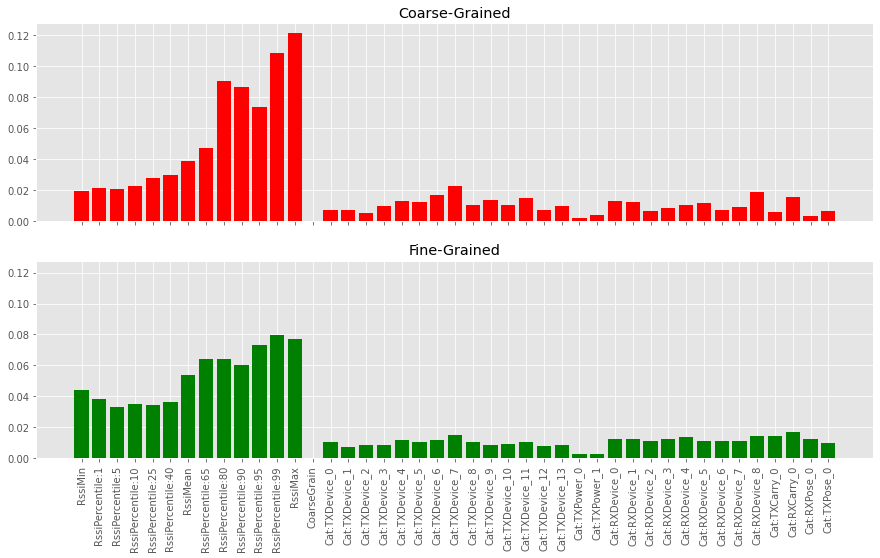

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

m0, m1 = report["model:cg=0"], report["model:cg=1"]
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(15, 8))
ax0, ax1 = axes.flatten()
ax0.bar(predictors, m0.feature_importances_, color="red")
ax0.set_title("Coarse-Grained")
ax0.tick_params(axis='x', rotation=90)
ax1.bar(predictors, m1.feature_importances_, color='green')
ax1.set_title("Fine-Grained")
ax1.tick_params(axis='x', rotation=90)